# Dependencies

In [ ]:
!pip install camb
!pip install cosmopower;
!git clone https://github.com/cosmopower-organization/lcdm.git;
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
!pip install uncertainties

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for camb: filename=camb-1.4.0-py3-none-any.whl size=1055421 sha256=e9c18c9c5e9e12c33c1d1d145bde1799ce66370c31138668102effd7f7c24da8
  Stored in directory: /root/.cache/pip/wheels/e1/7d/0f/767dc1b701363416abf5a57f105062e98960554f0c67ce5897
Successfully built camb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'lcdm'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 39 (delta 0), reused 4 (delta 0), pack-reused 34
Unpacking objects: 100% (39/39), 119.37 MiB | 13.40 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     \ 91.8 kB 5.3 MB/s

# Imports

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import os
from IPython.display import clear_output

import cosmopower
import camb

import uncertainties as uc
import uncertainties.umath as um

from tqdm import tqdm_notebook as tqdm

#Reading data

<ipython-input-3-11b620a55871>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = pd.Series(df.columns.str.replace("<>\s", ""))


       \ell,        cls,  \sigma_\ell
0        0.0    0.000000     0.000000
1        0.0    0.000000     0.000000
2        2.0  803.382583  3259.860350
3        3.0  593.978419  1302.449489
4        4.0  202.603600   650.895045
...      ...         ...          ...
1496  1496.0    0.002033     0.000264
1497  1497.0    0.001986     0.000263
1498  1498.0    0.002068     0.000261
1499  1499.0    0.002012     0.000260
1500  1500.0    0.002078     0.000259

[1501 rows x 3 columns]


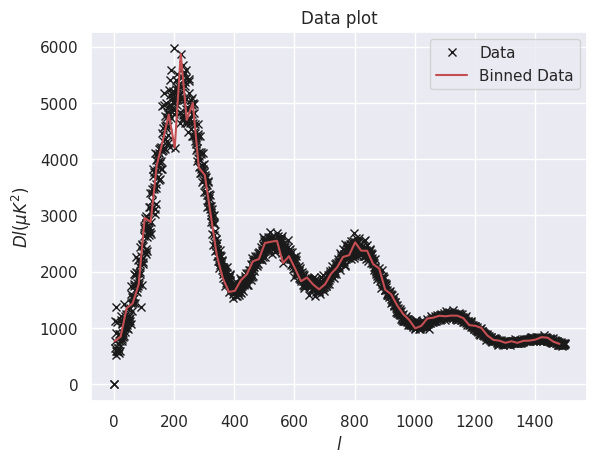

In [ ]:
data_path = "data_ombh2_omch2_noise.dat"
df = pd.read_csv(data_path, delimiter = " ")
df.columns = pd.Series(df.columns.str.replace("<>\s", ""))

ell = df[df.columns[0]]
ell_bin = ell[2::20]

cls = df[df.columns[1]]
dls = cls *  ell * (ell + 1) / (2 * np.pi)
dls_bin = dls[2::20]

sigma_ell = df[df.columns[2]] *  ell * (ell + 1) / (2 * np.pi)
sigma_ell_bin = sigma_ell[2::20]

plt.plot(ell, dls, "kx", label = "Data")
plt.plot(ell_bin, dls_bin, "r-", label = "Binned Data")
plt.xlabel("$l$")
plt.ylabel("$Dl(\mu K^2)$")
plt.title(f"Data plot")
plt.legend(loc = "best")

print(df)

#Loading the emulator

In [ ]:
#finding the path towards the emulator
root_path = os.path.abspath("")
#path_to_cosmopower_organization = root_path + '/cosmopower-organization/'
path_to_emulators = root_path + '/lcdm/'

In [ ]:
#dictionary for all possible models names -> possible future expansions
emulator_dict = {}

emulator_dict['lcdm'] = {} #we are only interested in lcdm for now

#setting up the names of the required files for lcdm
emulator_dict['lcdm']['TT'] = 'TT_v1'
emulator_dict['lcdm']['TE'] = 'TE_v1'
emulator_dict['lcdm']['EE'] = 'EE_v1'
emulator_dict['lcdm']['PP'] = 'PP_v1'
emulator_dict['lcdm']['PKNL'] = 'PKNL_v1'
emulator_dict['lcdm']['PKL'] = 'PKL_v1'
emulator_dict['lcdm']['DER'] = 'DER_v1'
emulator_dict['lcdm']['DAZ'] = 'DAZ_v1'
emulator_dict['lcdm']['HZ'] = 'HZ_v1'
emulator_dict['lcdm']['S8Z'] = 'S8Z_v1'

cp_tt_nn = {}
cp_te_nn = {}
cp_ee_nn = {}
cp_pp_nn = {}
cp_pknl_nn = {}
cp_pkl_nn = {}
cp_der_nn = {}
cp_da_nn = {}
cp_h_nn = {}
cp_s8_nn = {}

In [ ]:
#putting paths towards the emulators inside the dictionary, we are only
#interested in the tt one here
#path_to_emulators = root_path + mp +'/'

mp = "lcdm"
cp_tt_nn[mp] = cosmopower.cosmopower_NN(restore = True,
                          restore_filename = path_to_emulators + 'TTTEEE/' + emulator_dict[mp]['TT'])

#Parameters object

In [ ]:
class Parameters():
    def __init__(self, H0, ombh2, omch2, As, ns, tau, lmax):
        self.H0 = H0
        self.ombh2 = ombh2
        self.omch2 = omch2
        self.As = As
        self.ns = ns
        self.tau = tau
        self.lmax = lmax

    def __str__(self):
        return f"H0 = {self.H0:.3f}, ombh2 = {self.ombh2:.3f}, omch2 = {self.omch2:.3f}, As = {self.As:.3e}, ns = {self.ns:.3f}, tau = {self.tau:.3f}"

    def CAMB_lcdm(self):
        pars = camb.CAMBparams()

        pars.set_cosmology(H0 = self.H0, ombh2 = self.ombh2,
                          omch2 = self.omch2, mnu = 0.06, tau = self.tau,
                          omk = 0);

        pars.InitPower.set_params(As = 2e-9, ns = self.ns, r = 0);
        pars.set_for_lmax(lmax = self.lmax, lens_potential_accuracy = 0);

        results = camb.get_results(pars)

        power = results.get_cmb_power_spectra(pars, CMB_unit = "muK")

        totCL = power["total"]
        ls = np.arange(totCL.shape[0])

        return totCL[:, 0]

    def CP_lcdm(self):
        params_settings = {
                   'H0': self.H0,
                   'omega_b': self.ombh2,
                   'omega_cdm': self.omch2,
                   'ln10^{10}A_s': np.log(self.As * 1e10),
                   'tau_reio': self.tau,
                   'n_s': self.ns,
                   }

        mp = 'lcdm'

        params_cp = {}
        for key, value in params_settings.items():
            params_cp[key] = [value]

        predicted_tt_spectrum = cp_tt_nn[mp].ten_to_predictions_np(params_cp)

        #dimensionless to muK^2
        return predicted_tt_spectrum[0][:self.lmax + 1] * 1e12 * 2.72548**2

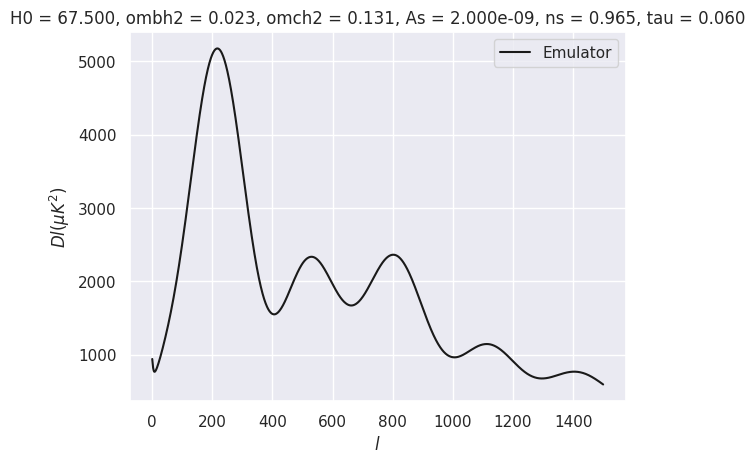

In [ ]:
p = Parameters(H0 = 67.500, ombh2 = 0.0226, omch2 = 0.131, As = 2.000e-09, ns = 0.965, tau = 0.060, lmax = 1500)

plt.plot(p.CP_lcdm(), "k-", label = "Emulator")
plt.xlabel("$l$")
plt.ylabel("$Dl(\mu K^2)$")
plt.title(f"H0 = 67.500, ombh2 = {p.ombh2:.3f}, omch2 = {p.omch2:.3f}, As = 2.000e-09, ns = 0.965, tau = 0.060")
plt.legend(loc = "best")

#Likelihood

In [ ]:
def chi_sq(p):
    obs = dls_bin
    exp = p.CP_lcdm()[2::20]
    return np.sum((obs - exp)**2 / sigma_ell_bin**2)

In [ ]:
def likelihood(p):
    return np.exp(-chi_sq(p)**2 / 2)

In [ ]:
def likelihood_log(p):
    return -chi_sq(p)**2 / 2

# Prior

In [ ]:
def get_prior(low, high):
    scale = high - low

    return scipy.stats.uniform(loc = low, scale = scale)

In [ ]:
def plot_prior(low, high, param):
    x = np.linspace(low - (0.4 * (high - low)), high + (0.4 * (high - low)), 100)

    pr = get_prior(low, high)
    pdf = pr.pdf(x)
    pdf_norm = pdf / np.max(pdf)

    plt.plot(x, pdf_norm, 'k-')
    plt.xlabel("x")
    plt.ylabel(f"{param} prior")

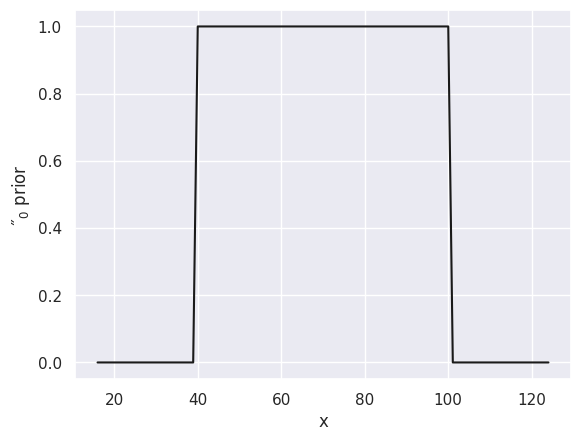

In [ ]:
H0_low = 39.99
H0_high = 100.01

H0_pr = get_prior(H0_low, H0_high)
plot_prior(H0_low, H0_high, "$\H_0$")

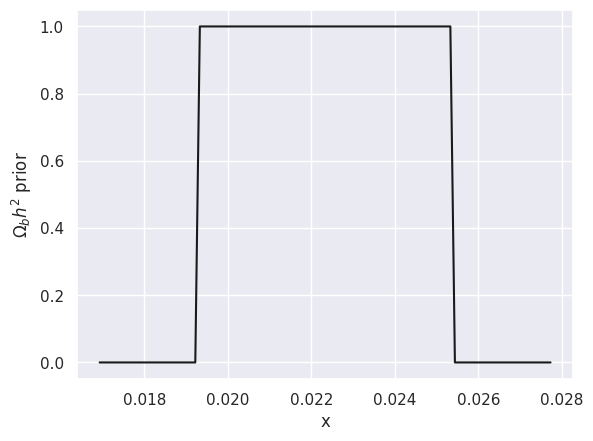

In [ ]:
ombh2_low = 0.01933
ombh2_high = 0.02533

ombh2_pr = get_prior(ombh2_low, ombh2_high)
plot_prior(ombh2_low, ombh2_high, "$\Omega_bh^2$")

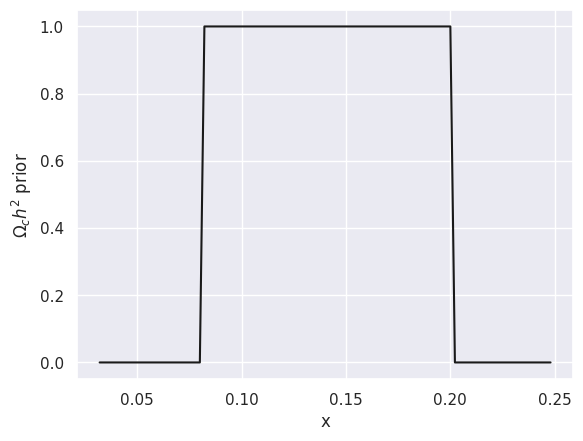

In [ ]:
omch2_low = 0.08
omch2_high = 0.20

omch2_pr = get_prior(omch2_low, omch2_high)
plot_prior(omch2_low, omch2_high, "$\Omega_ch^2$")

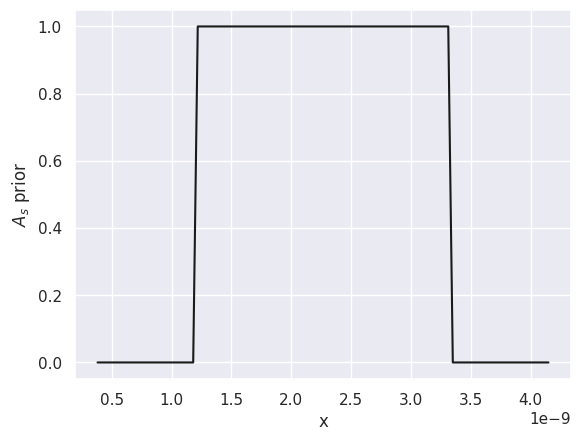

In [ ]:
As_low = np.exp(2.5) * 10**(-10)
As_high = np.exp(3.5) * 10**(-10)

As_pr = get_prior(As_low, As_high)
plot_prior(As_low, As_high, "$A_s$")

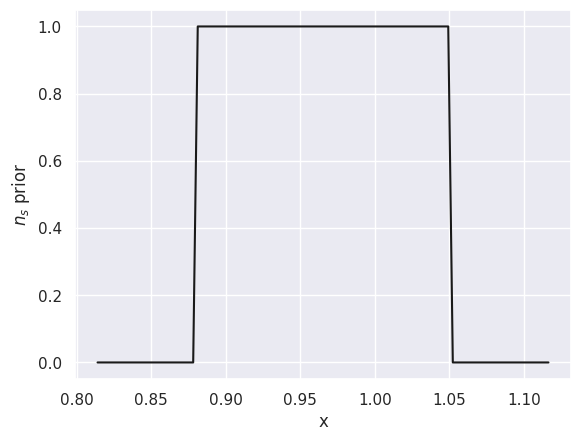

In [ ]:
ns_low = 0.8812
ns_high = 1.0492

ns_pr = get_prior(ns_low, ns_high)
plot_prior(ns_low, ns_high, "$n_s$")

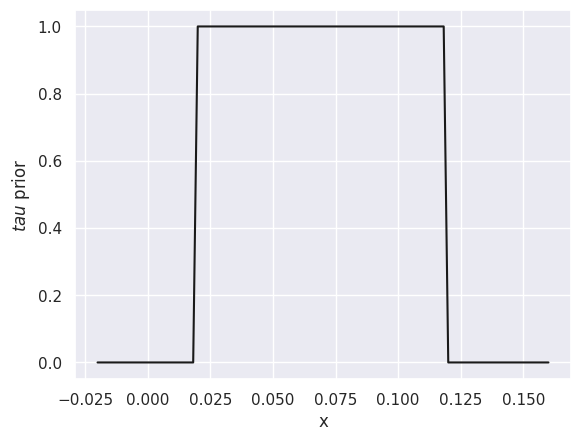

In [ ]:
tau_low = 0.02
tau_high = 0.12

tau_pr = get_prior(tau_low, tau_high)
plot_prior(tau_low, tau_high, "$tau$")

In [ ]:
def prior(p):
    h = H0_pr.pdf(p.H0)
    b = ombh2_pr.pdf(p.ombh2)
    c = omch2_pr.pdf(p.omch2)
    a = As_pr.pdf(p.As)
    n = ns_pr.pdf(p.ns)
    t = tau_pr.pdf(p.tau)

    if h * b * c * a * n * t == 0:
        return 0

    return 1

#Posterior

In [ ]:
def posterior(p):
    if prior(p) == 0.:
        return -np.inf
    else:
        return likelihood_log(p) + np.log(prior(p))

In [ ]:
def posterior_log(p):
    ombh2_post = ombh2_pr.pdf(p.ombh2)
    omch2_post = omch2_pr.pdf(p.omch2)

    return likelihood_log(p) + np.log(ombh2_post * omch2_post)

#MCMC

## Utils

In [ ]:
def get_parameters_object(ombh2_new, omch2_new):
    return Parameters(H0 = 67.5, ombh2 = ombh2_new, omch2 = omch2_new,
                      As = 2e-9, ns = 0.965, tau = 0.06, lmax = len(dls))

In [ ]:
def get_normal_distribution(p):
    means = [p.H0, p.ombh2, p.omch2, p.As, p.ns, p.tau]

    return scipy.stats.multivariate_normal(means, cov, allow_singular = True)

## Runtime

Debugger - will be deleted later

In [ ]:
!pip install -Uqq ipdb
import ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.9 MB/s eta 0:00:00


In [ ]:
%pdb on

Automatic pdb calling has been turned ON


##Initial variables

In [ ]:
n_steps = 100000

cov = np.array([[(0.002 * 67.5)**2, 0, 0, 0, 0, 0],
                [0, (0.002 * 0.02)**2 , 0, 0, 0, 0],
                [0, 0, (0.002 * 0.121)**2, 0, 0, 0],
                [0, 0, 0, (0.002 * 2e-9)**2, 0, 0],
                [0, 0, 0, 0, (0.002 * 0.965)**2, 0],
                [0, 0, 0, 0, 0, (0.002 * 0.060)**2]])

print(cov)

[[1.8225e-02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 1.6000e-09 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 5.8564e-08 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 1.6000e-23 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.7249e-06 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.4400e-08]]


##Runtime

In [ ]:
H0_s = []
ombh2_s = []
omch2_s = []
As_s = []
ns_s = []
tau_s = []

n_jumps = 0

H0_fg = H0_pr.rvs(1)[0]
ombh2_fg = ombh2_pr.rvs(1)[0]
omch2_fg = omch2_pr.rvs(1)[0]
As_fg = As_pr.rvs(1)[0]
ns_fg = ns_pr.rvs(1)[0]
tau_fg = tau_pr.rvs(1)[0]

p_curr = Parameters(H0_fg, ombh2_fg, omch2_fg, As_fg, ns_fg, tau_fg, len(dls))

H0_s.append(p_curr.H0)
ombh2_s.append(p_curr.ombh2)
omch2_s.append(p_curr.omch2)
As_s.append(p_curr.As)
ns_s.append(p_curr.ns)
tau_s.append(p_curr.tau)

for n in tqdm(range(n_steps), desc = "Progress"):
    #pick next guess
    values_next = get_normal_distribution(p_curr).rvs()
    #p_next = get_parameters_object(values_next[0], values_next[1])
    p_next = Parameters(values_next[0], values_next[1], values_next[2],
                        values_next[3], values_next[4], values_next[5],
                        len(dls))

    #compute posteriors
    post_curr = posterior_log(p_curr)
    post_next = posterior_log(p_next)

    #jump if the next step is closer to the real dist
    if post_curr < post_next:
        p_curr = p_next

        H0_s.append(p_curr.H0)
        ombh2_s.append(p_curr.ombh2)
        omch2_s.append(p_curr.omch2)
        As_s.append(p_curr.As)
        ns_s.append(p_curr.ns)
        tau_s.append(p_curr.tau)

        n_jumps += 1

        continue

    #if not, we check if it would be an exploring step
    alpha = post_next - post_curr

    u = scipy.stats.uniform.rvs()

    #if so, we explore
    if np.log(u) < alpha:
        p_curr = p_next

        H0_s.append(p_curr.H0)
        ombh2_s.append(p_curr.ombh2)
        omch2_s.append(p_curr.omch2)
        As_s.append(p_curr.As)
        ns_s.append(p_curr.ns)
        tau_s.append(p_curr.tau)

        n_jumps += 1

        continue

    #if everything fails, we discard the step
    n -= 1

<ipython-input-22-0a5a04119131>:5: RuntimeWarning: divide by zero encountered in log
  return likelihood_log(p) + np.log(ombh2_post * omch2_post)


In [ ]:
from scipy.stats import norm

def plot_result(trace, name):
    fig, (ax1, ax2) = plt.subplots(2, 1)

    ax1.plot(trace, color = "black")

    ax1.axvline(x = 10000, ls = ":", color = "red")
    ax1.grid(axis = "x", alpha = 0.1, color = "black")
    ax1.grid(axis = "y", alpha = 0.1, color = "black")

    ax1.set_xlabel("Iteration")
    ax1.set_ylabel(name)

    ax2.hist(trace[10000:], color = "black")
    ax2.set_xlabel(name)
    ax2.set_ylabel("Frequency")

    plt.savefig(name + ".png")

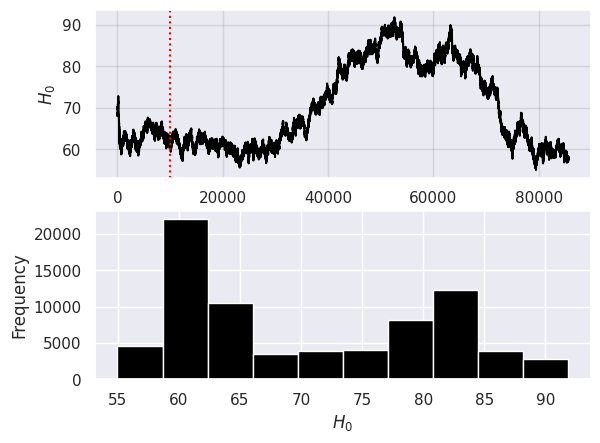

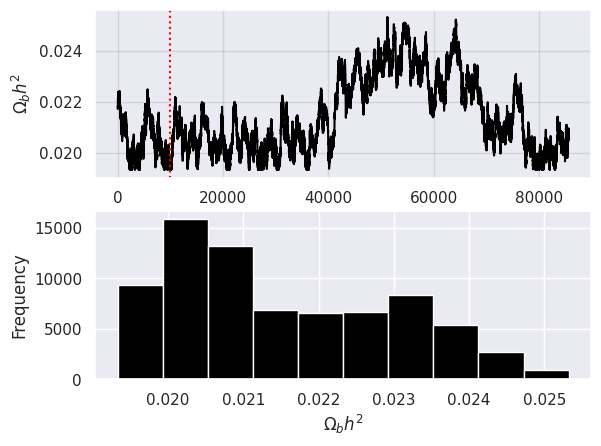

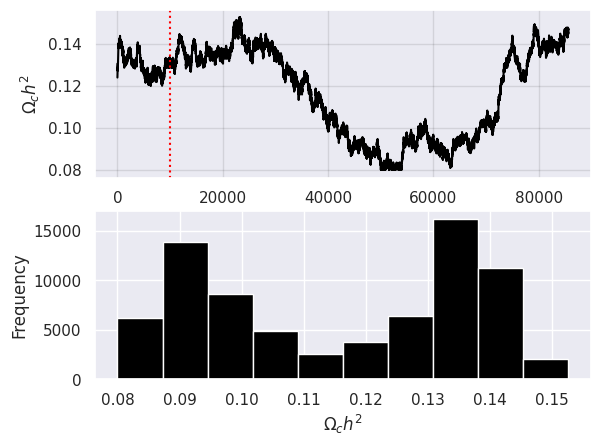

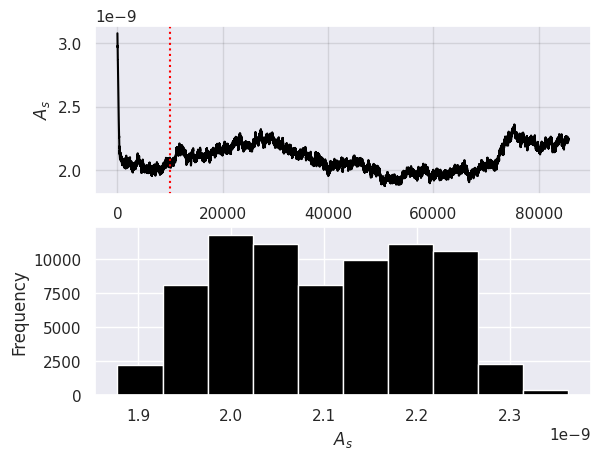

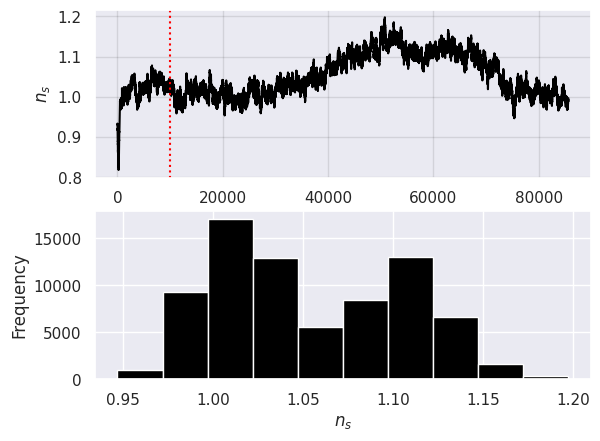

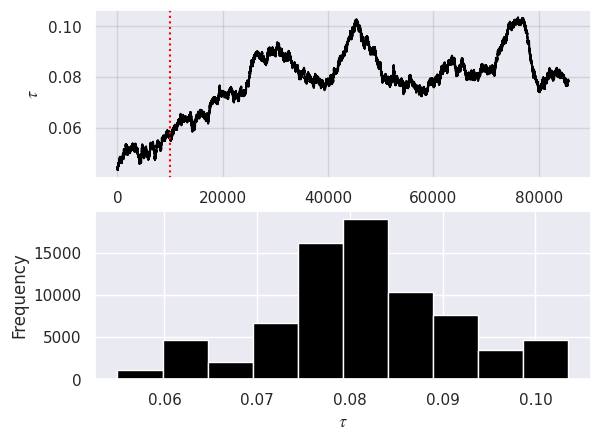

In [ ]:
H0_fit = uc.ufloat(np.mean(H0_s[10000:]), np.std(H0_s[10000:]))
plot_result(H0_s, "$H_0$")

ombh2_fit = uc.ufloat(np.mean(ombh2_s[10000:]), np.std(ombh2_s[10000:]))
plot_result(ombh2_s, "$\Omega_bh^2$")

omch2_fit = uc.ufloat(np.mean(omch2_s[10000:]), np.std(omch2_s[10000:]))
plot_result(omch2_s, "$\Omega_ch^2$")

As_fit = uc.ufloat(np.mean(As_s[10000:]), np.std(As_s[10000:]))
plot_result(As_s, "$A_s$")

ns_fit = uc.ufloat(np.mean(ns_s[10000:]), np.std(ns_s[10000:]))
plot_result(ns_s, "$n_s$")

tau_fit = uc.ufloat(np.mean(tau_s[10000:]), np.std(tau_s[10000:]))
plot_result(tau_s, "$𝜏$")

In [ ]:
print(f"H0 = {H0_fit}")
print(f"ombh2 = {ombh2_fit}")
print(f"omch2 = {omch2_fit}")
print(f"As = {As_fit}")
print(f"ns = {ns_fit}")
print(f"tau = {tau_fit}")

H0 = 70+/-10
ombh2 = 0.0215+/-0.0015
omch2 = 0.116+/-0.021
As = (2.10+/-0.10)e-09
ns = 1.05+/-0.05
tau = 0.081+/-0.010


In [ ]:
n_jumps / n_steps

0.856

4.033093598948328


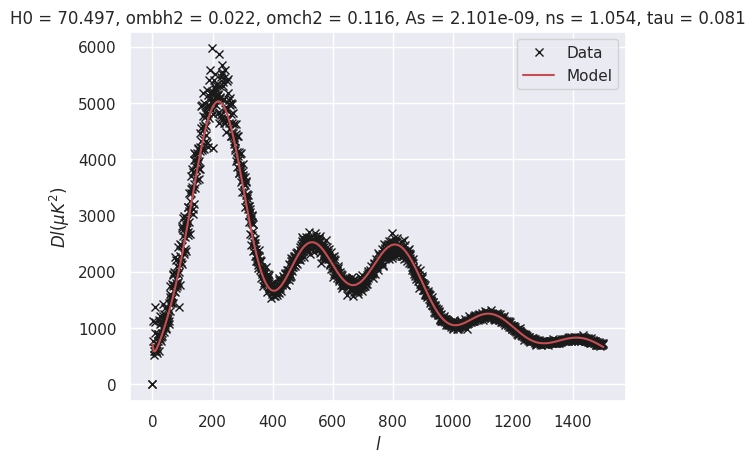

In [ ]:
fit = Parameters(H0_fit.nominal_value, ombh2_fit.nominal_value,
                 omch2_fit.nominal_value, As_fit.nominal_value,
                 ns_fit.nominal_value, tau_fit.nominal_value, len(dls))

plt.plot(ell, dls, "kx", label = "Data")
plt.plot(fit.CP_lcdm(), "r-", label = "Model")
plt.xlabel("$l$")
plt.ylabel("$Dl(\mu K^2)$")
plt.title(f"H0 = {fit.H0:.3f}, ombh2 = {fit.ombh2:.3f}, omch2 = {fit.omch2:.3f}, As = {fit.As:.3e}, ns = {fit.ns:.3f}, tau = {fit.tau:.3f}")
plt.legend(loc = "best")

plt.savefig("final_fit.png")
print(chi_sq(fit))

In [ ]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


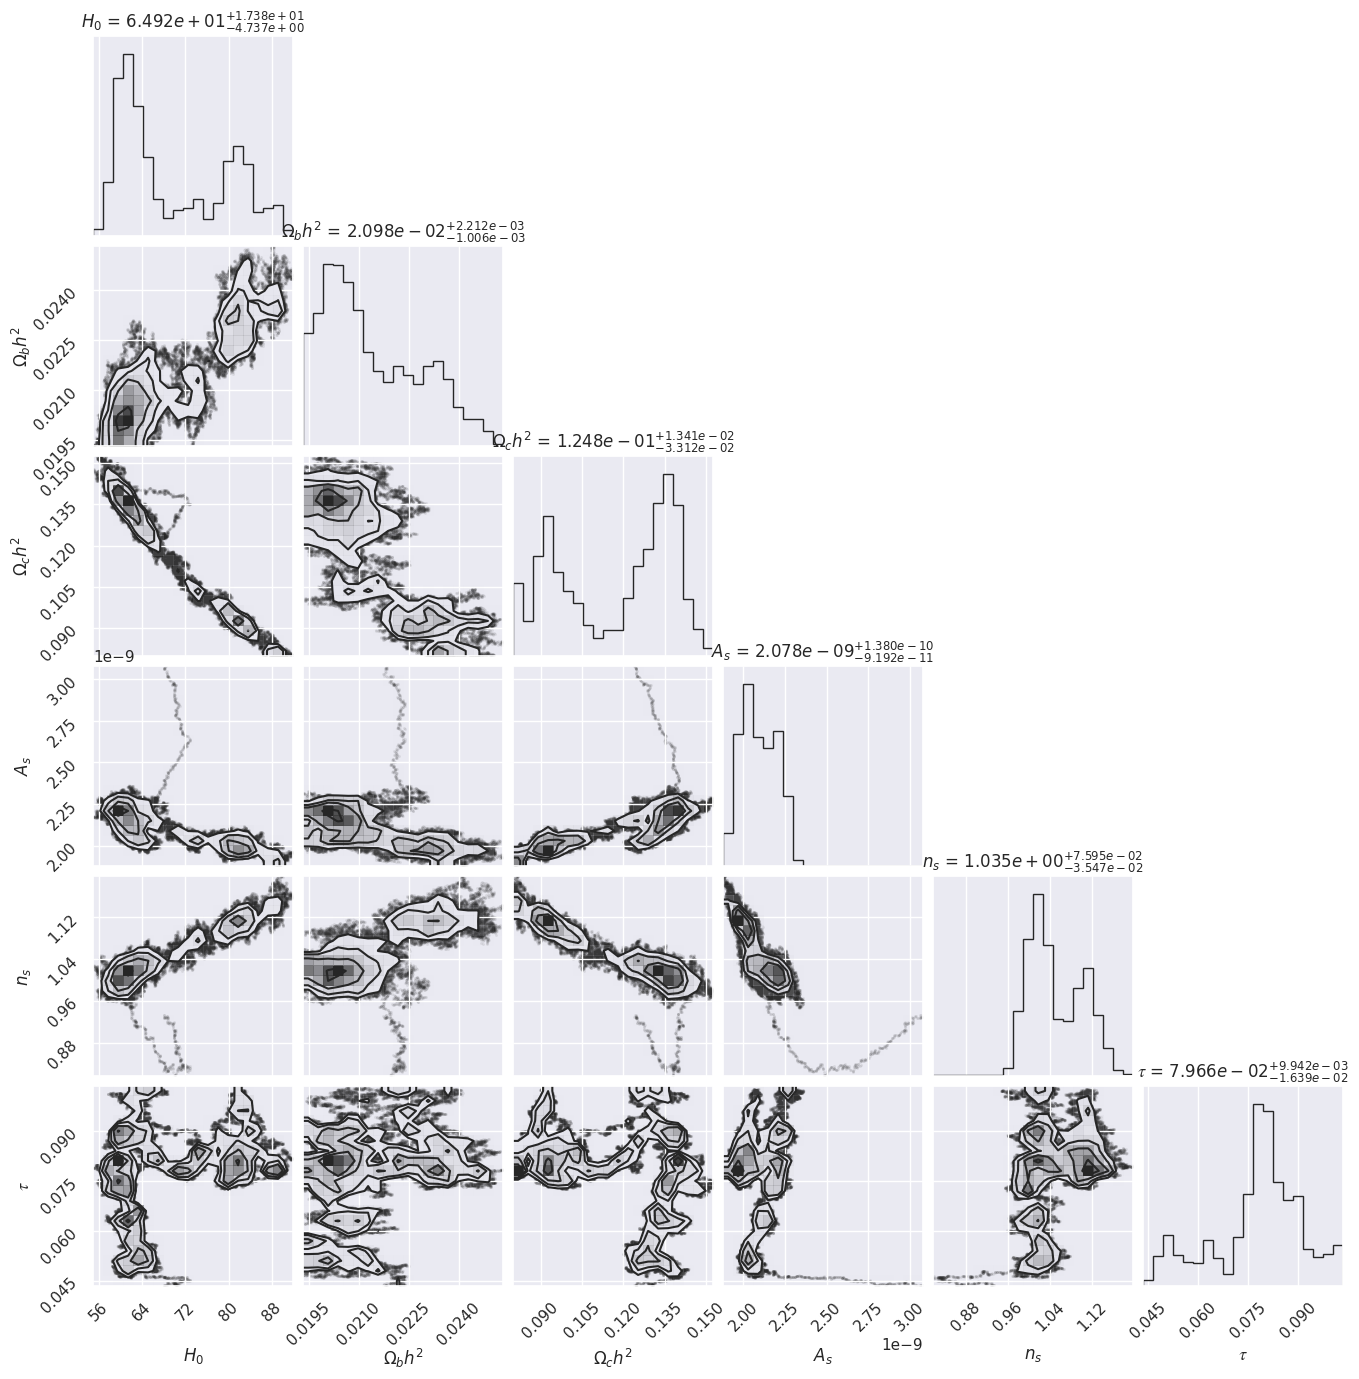

In [ ]:
burn_in = 0
chains = np.concatenate([[H0_s[burn_in:]], [ombh2_s[burn_in:]], [omch2_s[burn_in:]], [As_s[burn_in:]], [ns_s[burn_in:]], [tau_s[burn_in:]]]).transpose()

import corner
figure = corner.corner(
    chains,
    labels=[
        r"$H_0$",
        r"$\Omega_bh^2$",
        r"$\Omega_ch^2$",
        r"$A_s$",
        r"$n_s$",
        r"$𝜏$",
    ],
    show_titles=True,
    title_fmt='.3e',
    title_kwargs={"fontsize": 12},
)
plt.savefig("corner_plot.png")